推荐系统的相似度计算方式有很多，通常根据所处理的数据集来进行选择：
* 实现用户协同过滤、物品协同过滤、矩阵分解算法
* 将rating.dat按照8:2划分为训练集与测试集
* 采用MSE作为评测指标
***
数据集特点：
rating.dat

-用户编号：1-6040

-物品（电影）编号：1-3952

-评分范围：1-5（5级制），注意没有0分，0分可以用于判定用户没有给该电影评过分


### 矩阵分解方法介绍

**数学原理：奇异值分解（SVD）**

$M_{k}=U_{k} \times \Sigma_{k} \times V_{k}^{\top}$

* $M_{k}$: 用户-物品评分矩阵，维度是(m,n)
* $U_{k}$： 分解的用户矩阵，维度是(m,k)
* $V_{k}$: 分解的物品矩阵，维度是(k,n)
* $\Sigma_{k}$:维度是(k,k)
$\hat{r}_{u i}=\bar{r}_{u}+U_{k}(u) \times \Sigma_{k} \times V_{k}^{T}(i)$
***
**最基本的MF模型**

用户u对物品i兴趣度的计算：

$r_{u i}=p_{u}^{T} q_{i}=\sum_{f=1}^{F} p_{u, k} q_{i, k}$

* F：隐特征的个数
* $p_{u}$: 用户u的隐特征向量(参数)
* $q_{i}$: 物品i的隐特征向量(参数)

参数的计算方式：
$C=\sum_{(u, i) \in K}\left(r_{u i}-\hat{r}_{u i}\right)^{2}=\sum_{(u, j) \in K}\left(r_{u i}-\sum_{f=1}^{F} p_{u, k} q_{i, k}\right)^{2}+\lambda\left\|p_{u}\right\|^{2}+\lambda\left\|q_{i}\right\|^{2}$
***
对最基本的模型进行改进(**原因见论文**)：

$b_{u i}=\mu+b_{i}+b_{u}$

$\hat{r}_{u i}=\mu+b_{i}+b_{u}+q_{i}^{T} p_{u}$

* $\mu$: globol average(所有物品的均分) 
* $b_{i}$: item bias
* $b_{u}$: user bias
* $q_{i}^{T} p_{u}$: user-item interaction

损失函数：

$\min _{p \cdot q \cdot b \cdot} \sum_{(u, i) \in \kappa}\left(r_{u i}-\mu-b_{u}-b_{i}-p_{u}^{T} q_{i}\right)^{2}+\lambda$

$\lambda=\left(\left\|p_{u}\right\|^{2}+\left\|q_{i}\right\|^{2}+b_{u}^{2}+b_{i}^{2}\right)$
***

**参考资料**
* [参考代码1](https://github.com/AmazingDD/MF-pytorch/blob/master/BiasMFRecommender.py)
* [参考代码2](https://github.com/AmazingDD/daisyRec/blob/dev/daisy/model/pair/FMRecommender.py)
* 论文：MATRIX RECOMMENDER TECHNIQUES FOR FACTORIZATION SYSTEMS-2009（值得反复阅读）

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

### 数据加载与预处理

In [0]:
path='/content/drive/My Drive/recommend_system/data/'
train_df = pd.read_csv(path+'train_df.csv')
test_df = pd.read_csv(path+'test_df.csv')
user_item_matrix = pd.read_csv(path+'user_item_matrix.csv')
user_item_matrix_np = user_item_matrix.values

In [0]:
# build user-item dic，  user_id:item_list
# build item-user dic,  item_id:user_list
def build_dictionary(train_df):
  user_item_dic={}
  item_user_dic={}
  for row_record in tqdm(train_df.itertuples()):
    user_id = getattr(row_record,'user_id')
    item_id = getattr(row_record,'item_id')
    rating = getattr(row_record,'rating')
    # build user-->item dictionary
    if user_id in user_item_dic:
      user_item_dic.get(user_id).append(item_id)
    else:
      user_item_dic[user_id] = [item_id]
    # build item-user dictionary
    if item_id in item_user_dic:
      item_user_dic.get(item_id).append(user_id)
    else:
      item_user_dic[item_id] = [user_id]

  return user_item_dic,item_user_dic 

In [8]:
user_item_dic,item_user_dic = build_dictionary(train_df)

800193it [00:01, 548674.47it/s]


In [0]:
# 将测试数据转换为3个列表
def extract_df(df):
  data = df.values
  user_id_list = []
  item_id_list = []
  rating_list = []
  for i in range(data.shape[0]):
    user_id_list.append(data[i][0]) 
    item_id_list.append(data[i][1]) 
    rating_list.append(data[i][2])
  return user_id_list,item_id_list,rating_list

In [0]:
test_user_id_list,test_item_id_list,test_rating_list = extract_df(test_df)

In [0]:
train_user_id_list,train_item_id_list,train_rating_list = extract_df(train_df)

In [0]:
# item_id,user_id list ----> item_index,user_index list
def id_to_embed_index(user_test_list,item_test_list,item_user_dic,user_item_matrix):
  itemID_train_list = user_item_matrix.columns
  print(len(itemID_train_list))
  # -------------未在训练集中出现的测试集物品id编号-----------------
  undefined_index = len(itemID_train_list) 
  # -------------在训练集中出现的物品id编号-------------------------
  item_map_dic={}  # 用于用户评分矩阵是无序的，建立item_id-->index的映射
  for i,col_id in enumerate(itemID_train_list):
    item_map_dic[int(col_id)] = i

  # -------------获取在测试集出现，未在训练集中出现的物品id----------
  rare_item_id_list = [] 
  for item_id in item_test_list:
    if item_id not in item_user_dic:
      rare_item_id_list.append(item_id)
  print(rare_item_id_list)


  # -------------将测试集中的id转换为编号----------------------
  user_embed_index = []
  item_embed_index = []
  for user_id in user_test_list: # user_id = index+1
    user_embed_index.append(user_id-1)

  for item_id in item_test_list:
    if item_id in item_user_dic:
      item_embed_index.append(item_map_dic[item_id])
    else:
      item_embed_index.append(undefined_index)
  return user_embed_index,item_embed_index,item_map_dic

def id_to_embed_index2(user_list,item_list,item_map_dic):
  user_embed_index = []
  item_embed_index = []
  for user_id in user_list: # user_id = index+1
    user_embed_index.append(user_id-1)
  for item_id in item_list:
    item_embed_index.append(item_map_dic[item_id])
  return user_embed_index,item_embed_index



In [13]:
test_user_embed_index,test_item_embed_index,item_map_dic=id_to_embed_index(test_user_id_list,test_item_id_list,item_user_dic,user_item_matrix)
# 将测试集中的user_id,item_id转换为模型的中embedding_index
# 注意点：测试集中出现但训练集中没有出现的id都定义为rare id,使用最后一个embedding_index
# 用户embedding_num = user_num_train || 物品embedding_num = item_num_train + 1(这里的1分配给rare id)

3683
[3651, 658, 3291, 576, 641, 401, 3722, 401, 1115, 1145, 790, 3242, 3242, 872, 3779, 3065, 3202, 3242, 878, 701, 843, 3651, 3290, 1145, 1434, 3323, 2198, 2703, 1434, 2198]


In [0]:
train_user_embed_index,train_item_embed_index=id_to_embed_index2(train_user_id_list,train_item_id_list,item_map_dic)

### 构建数据集

In [0]:
class RateDataset(Dataset):
    def __init__(self, user_tensor, item_tensor, target_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]
    
    def __len__(self):
        return self.user_tensor.size(0)

In [0]:
trian_u = torch.LongTensor(train_user_embed_index)
train_i = torch.LongTensor(train_item_embed_index)
train_r = torch.FloatTensor(train_rating_list)

test_u = torch.LongTensor(test_user_embed_index)
test_i = torch.LongTensor(test_item_embed_index)
test_r = torch.FloatTensor(test_rating_list)

In [0]:
batch_size_tr = 10000
train_dataset = RateDataset(trian_u,train_i,train_r)
train_data = DataLoader(train_dataset,batch_size=batch_size_tr)

In [0]:
batch_size_te = 5000
test_dataset = RateDataset(test_u,test_i,test_r)
test_data = DataLoader(test_dataset,batch_size=batch_size_te)

In [0]:
# Matrix Factorization With Biases
class LFM(torch.nn.Module):
  def __init__(self,num_user,num_item,hidden,mu):
    super(LFM,self).__init__()
    self.mu = mu
    self.user_embed = nn.Embedding(num_user,hidden)
    self.item_embed = nn.Embedding(num_item,hidden)
    self.bias_u = nn.Embedding(num_user,1)
    self.bias_i = nn.Embedding(num_item,1)
    self.init_params()

  def init_params(self):
    nn.init.normal_(self.user_embed.weight, std=0.01)
    nn.init.normal_(self.item_embed.weight, std=0.01)
    nn.init.constant_(self.bias_u.weight, 0.0)
    nn.init.constant_(self.bias_i.weight, 0.0)

  def forward(self,user_indexs,item_indexs): 
    P = self.user_embed(user_indexs) # [batch_num,hidden]
    Q = self.item_embed(item_indexs) # [batch_num,hidden]
    interaction = torch.mul(P,Q).sum(dim=1).unsqueeze(dim=1) # element-wise product [batch_num,1]
    return self.mu+self.bias_u(user_indexs)+self.bias_i(item_indexs)+interaction # [batch_num,1]

### 模型训练



In [0]:
import os
import glob   # lists of files matching given patterns, just like the Unix shell

In [21]:
print(len(item_user_dic))

3683


### L2正则化主要是防止过拟合问题，并非总是help，实际上数据量比较的的情况下可以不添加。

In [0]:
num_user = 6040
num_item = len(item_user_dic)+1
hidden = 10
mu = 3
lr = 0.1
# weight_decay = 0.01
epoch_num = 500
early_stop = 5

model_dir = '/content/drive/My Drive/recommend_system/model_dir/'
model = LFM(num_user,num_item,hidden,mu)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [0]:
# 动态调整学习率
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [23]:
best_loss = float('inf')
print(best_loss < 10)
print(len(train_user_embed_index))

False
800193


In [0]:
loss_list = []
best_epoch = 0
bad_count = 0
# 模型每次训练前没有进行梯度更新zero_grad，导致模型使用了已有参数进行了训练

best_loss = float('inf')
model.train() 
for epoch in range(epoch_num):
  loss_sum = 0
  for bid, batch in tqdm(enumerate(train_data)):
        u, i, r = batch[0], batch[1], batch[2]
        r = r.float()
        # forward pass
        preds = model(u, i)
        loss = criterion(preds.squeeze(dim=1), r)
        loss_sum += loss.item()
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  # print('Epoch [{}/30], Loss: {:.4f}'.format(epoch + 1, loss.item()))
  if bad_count == early_stop:
    print("early stop at {}".format(epoch))
    break
  bad_count += 1
  tmp_loss = loss_sum/(801)
  print(tmp_loss)
  loss_list.append(tmp_loss)
  if tmp_loss < best_loss:
    bad_count = 0 
    print("New record!!!!")
    best_loss = tmp_loss
    best_epoch = epoch
    torch.save(model.state_dict(),model_dir+'{}.pkl'.format(epoch))
    files = glob.glob(model_dir+'*.pkl')
    for file in files:
      tmp = file.split('/')[-1]
      tmp = tmp.split('.')[0]
      epoch_nb = int(tmp)
      if epoch_nb < best_epoch:
        os.remove(file)

In [0]:
def myFigPlot(listX,listY,lengendName='loss',col="red"):
    fig = plt.gcf()
    fig.set_size_inches(6,6)                 # 图像大小设定
    plt.plot(listX,listY,color=col,label = lengendName)   # 画图，并指定图像颜色，以及标签

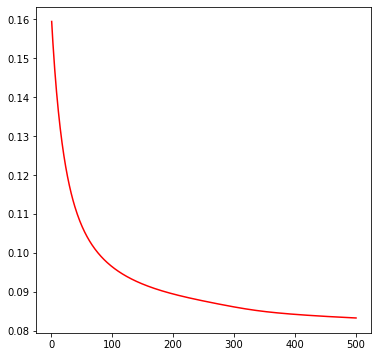

In [0]:
listX = range(1,len(loss_list)+1)
listY = loss_list
myFigPlot(listX,listY)

In [24]:
best_epoch=1093
print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load(model_dir+'{}.pkl'.format(best_epoch)))

Loading 1093th epoch


<All keys matched successfully>

In [25]:
model.eval()
pred_list = []
for bid, batch in tqdm(enumerate(test_data)):
  u, i, r = batch[0], batch[1], batch[2]
  preds = model(u, i)
  pred_list.extend(preds.squeeze(dim=1).detach().numpy().tolist())

41it [00:03, 13.04it/s]


In [26]:
from sklearn.metrics import mean_absolute_error
MAE_loss = mean_absolute_error(pred_list,test_rating_list)
print(MAE_loss)   

0.7221592643492132
